## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_vertical_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\coco\\indoor\\wavelet\\vertical\\blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


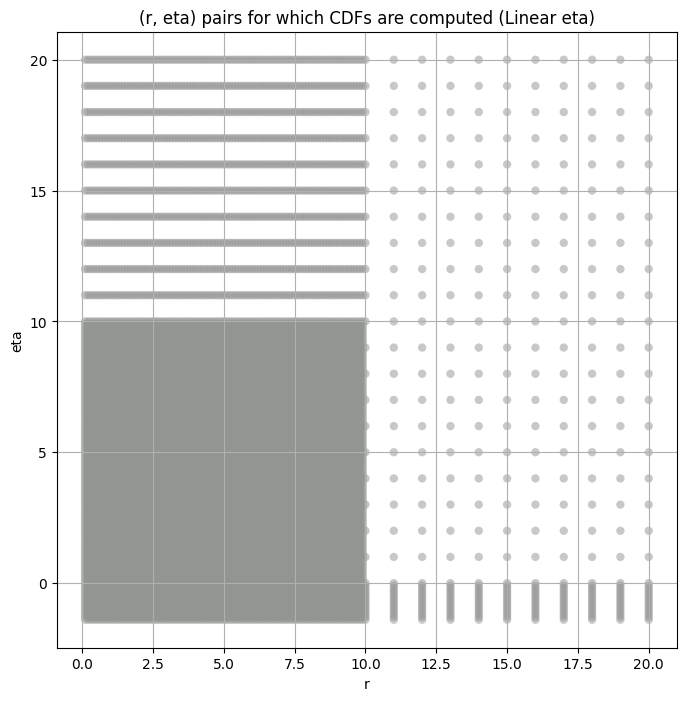

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      4899.646500  4445.868000  5360.411600   0.087138   -0.147728   
3      1238.654300  1163.662800  1315.236600   1.605114    1.235477   
4       263.909800   248.471220   279.795900   3.268377    2.747256   
5        51.531197    47.837180    55.759390   6.744933    4.699508   
6         9.183132     8.392665    10.085384  10.684343    7.591162   
7         1.610812     1.448076     1.795833  15.269720   10.921982   
8         0.307680     0.268638     0.360814  29.931046   15.846058   
9         0.068229     0.057962     0.083432  47.115646   21.587310   

       kurt_upper  total_samples  
layer                             
2        0.346288           1604  
3        2.010365           6416  
4        3.893440          25664  
5       17.004566         102656  
6       24.656334         410624  
7       31.450808        1642496  
8      102.204470        6569984  
9      168.762150       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      4899.646500    4899.646484     4067.469727     3486.512695   
3      1238.654300    1238.654297     1114.506470     1040.657593   
4       263.909800     263.909790      252.079407      243.826401   
5        51.531197      51.531197       50.171516       49.379025   
6         9.183132       9.183132        8.873129        8.679515   
7         1.610812       1.610813        1.541523        1.498872   
8         0.307680       0.307680        0.287536        0.276809   
9         0.068229       0.068229        0.062328        0.059333   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         3033.757324      2675.201416      2090.753906      1637.050659   
3          978.955078       925.263977       833.396179       754.787537   
4          236.560974       230.002472       218.465775       208.431885   
5           48.701786        48.100117        47.016304        46.031673   
6            8.514946         8.367455         8.106821         7.876569   
7            1.462525         1.430265         1.373819         1.324523   
8            0.267951         0.260213         0.246930         0.235657   
9            0.056921         0.054860         0.051414         0.048569   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          1265.395386       978.090332       751.768005       288.882385  
3           688.950317       632.311707       582.972107       464.310852  
4           199.696396       191.903793       184.796722       166.554642  
5            45.126453        44.272385        43.463005        41.282219  
6             7.668834         7.477969         7.301584         6.836836  
7             1.280558         1.240685         1.204161         1.109520  
8             0.225780         0.216981         0.209037         0.189009  
9             0.046135         0.044007         0.042116         0.037452

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.015611096961686 4899.6465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.030914049477145406 4067.4697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.047013477004574755 3486.5127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.061094203804798686 3033.7573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07431045081721267 2675.2014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.09804212263919275 2090.754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.1237405420310207 1637.0507


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.15143104530092147 1265.3954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.17893030117788766 978.09033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.20432720268109297 751.768


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.278358984611933 288.8824
Number of samples: 1604, Without approximation : 1604


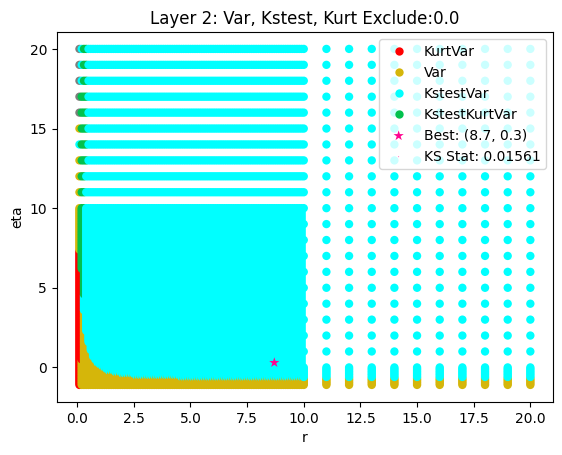

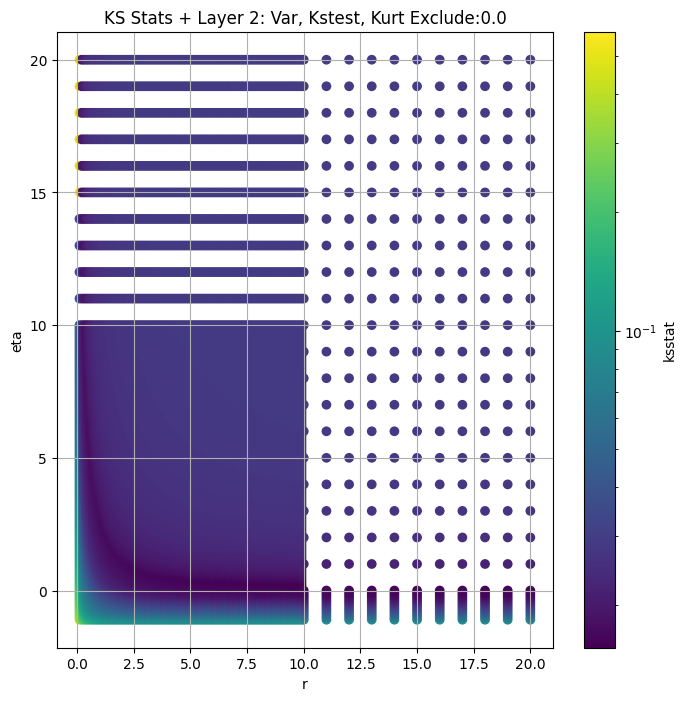

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.006764872833030733 1238.6543


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.009749744851669517 1114.5065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.014902726551634486 1040.6576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.019575423743514113 978.9551


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.02425558217145697 925.264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.03309012169937638 833.3962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.04076194456854125 754.78754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.04818369473065086 688.9503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05520517458249952 632.3117


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06221116480193832 582.9721


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08157987836928675 464.31085
Number of samples: 6416, Without approximation : 6416


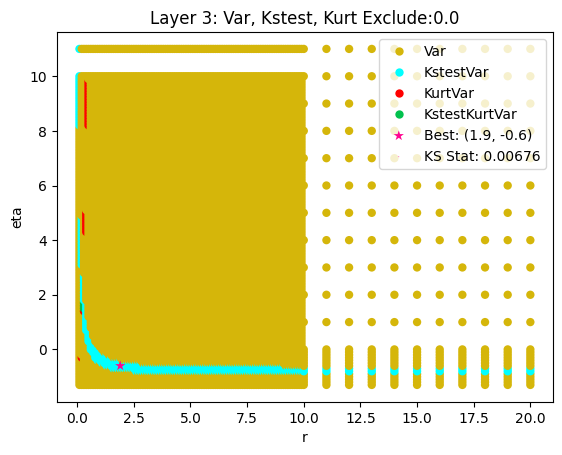

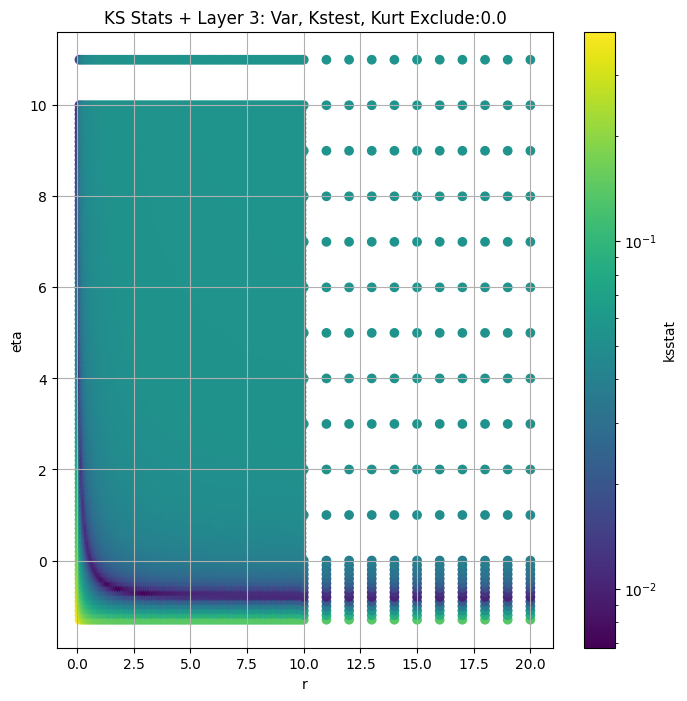

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0025962406605707644 263.9098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.003931416374675423 252.0794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.005197414308096282 243.8264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.006414191248089951 236.56097


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.007583287576146458 230.00247


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.009813877413343386 218.46577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.011945354685641174 208.43188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.013927148164875724 199.6964


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.016459321787608214 191.9038


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.018981219695537566 184.79672


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.02594406550849699 166.55464
Number of samples: 25664, Without approximation : 25664


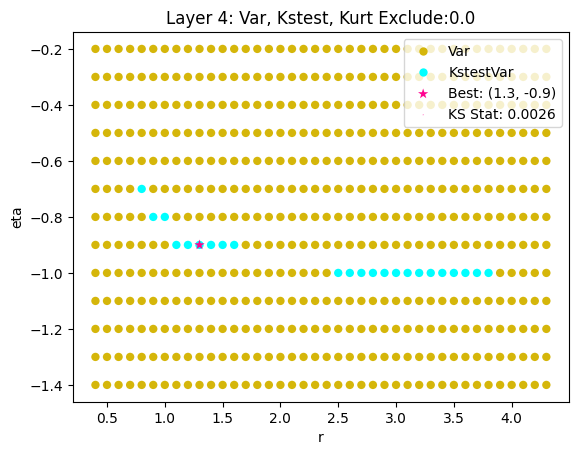

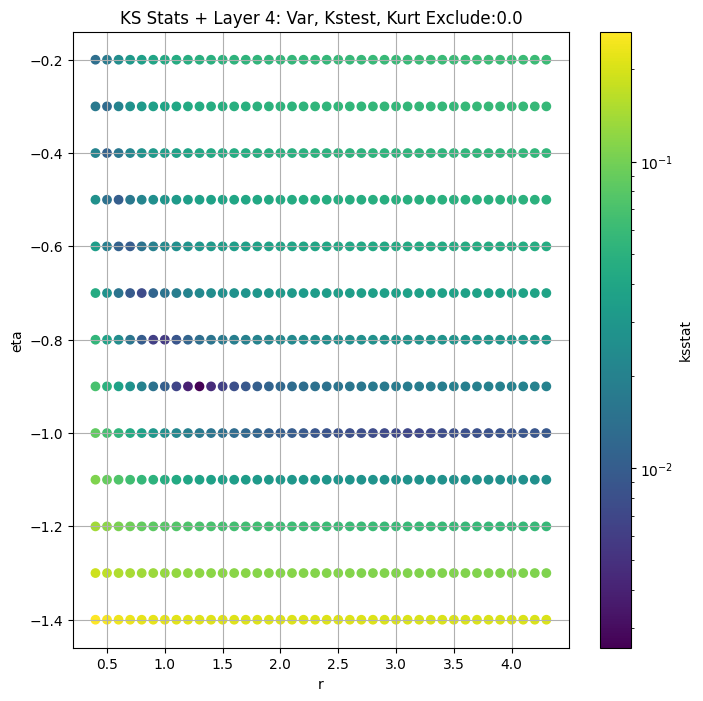

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.005407192109893155 51.531197


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.0063260959820207185 50.171516


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.007331945556239061 49.379025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.007554374828726507 48.701786


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.006809829679644053 48.100117


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.007087304786958515 47.016304


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.008230150363367716 46.031673


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008607398863930138 45.126453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.008535144066759037 44.272385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.009547247466393904 43.463005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009664472508943311 41.28222
Number of samples: 100000, Without approximation : 102656


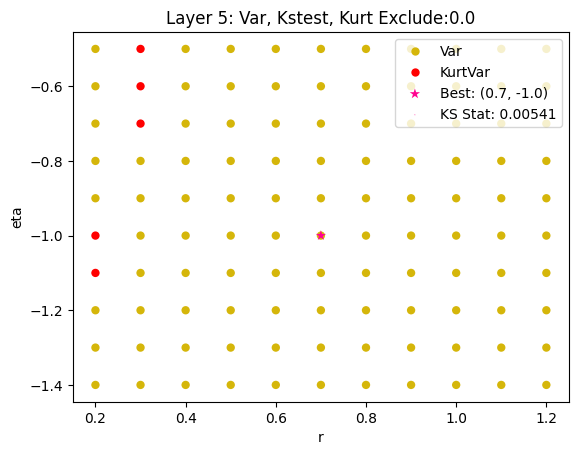

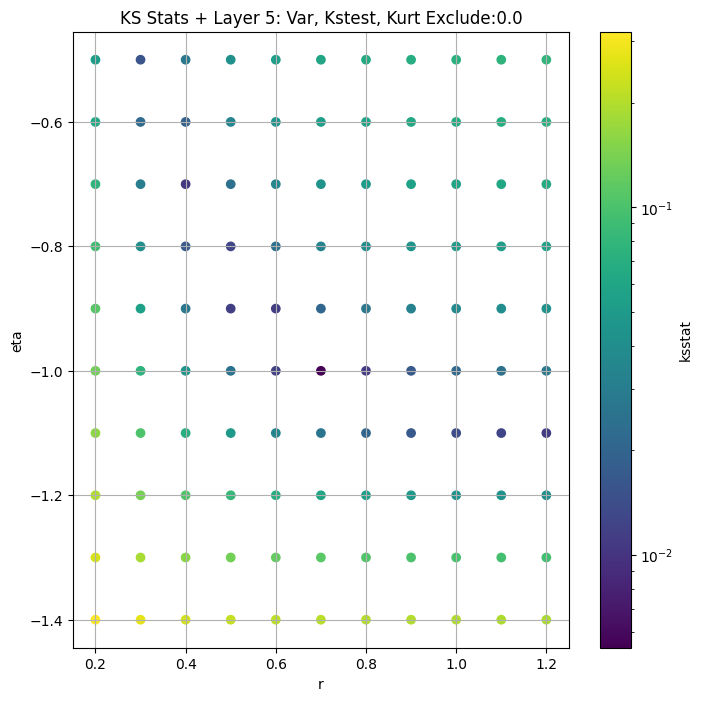

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011903611663368549 9.183132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.01283944760095268 8.873129


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.011603727329931535 8.679515


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.010527817858583255 8.514946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.009542760350908841 8.3674555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008812580410660471 8.106821


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.010084602455009972 7.8765693


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.011266477252581869 7.668834


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.011729418978710604 7.477969


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.011634398222948594 7.3015842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.012124217379874902 6.8368363
Number of samples: 100000, Without approximation : 410624


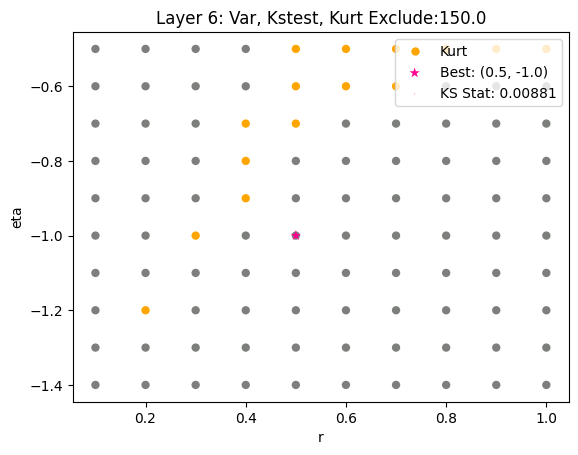

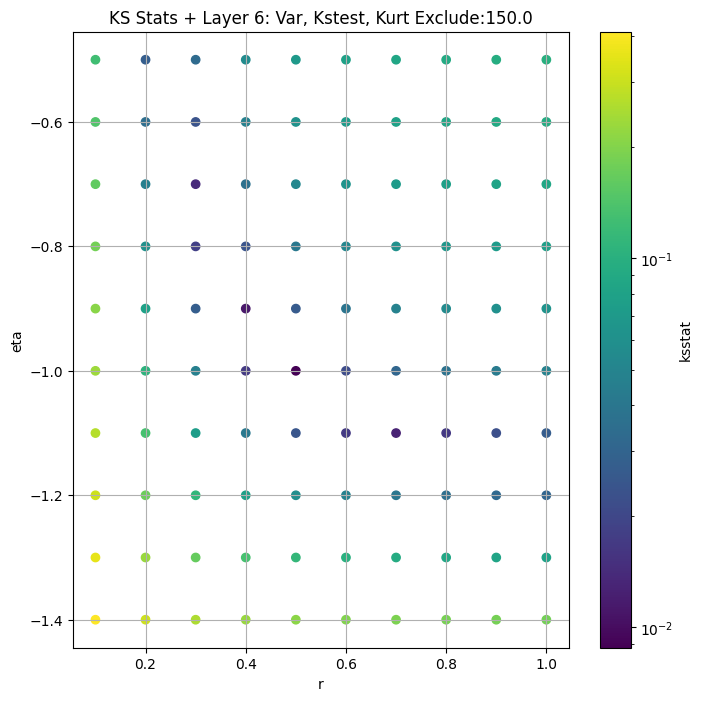

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.01501867764731396 1.6108125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.014008470145002894 1.5415225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.013690594653308186 1.4988716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.013655652946161334 1.4625255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.01444273513076011 1.4302647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.015885102453034095 1.3738188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.016851817998666252 1.3245232


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.015963091735304802 1.2805582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.015606317448824791 1.2406847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.01527362171017188 1.2041607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.014349975879156929 1.1095203
Number of samples: 100000, Without approximation : 1642496


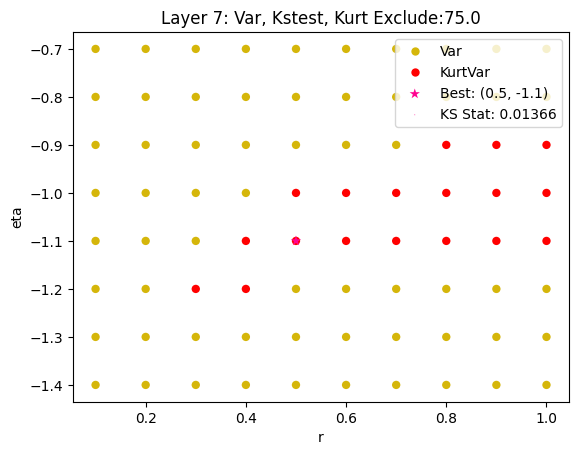

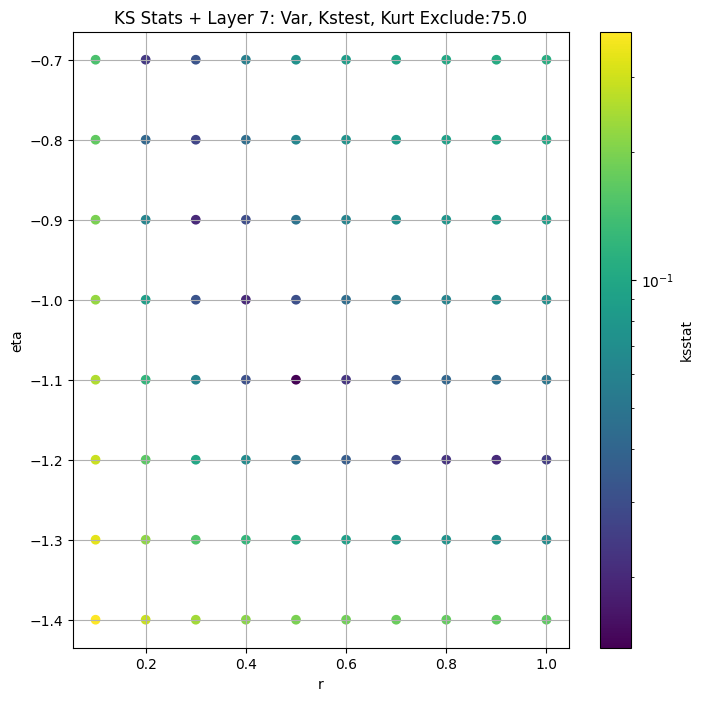

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0069720390989038705 0.30767962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.00880032153237903 0.28753555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006806183004995248 0.27680865


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006311193151721739 0.26795134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.007125934165815771 0.26021293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.005860252586747078 0.24692981


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.007009373306664422 0.23565683


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.008240873889388177 0.22578008


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009164477497640627 0.21698081


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.008050879077608063 0.20903724


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.01068316546712239 0.18900877
Number of samples: 100000, Without approximation : 6569984


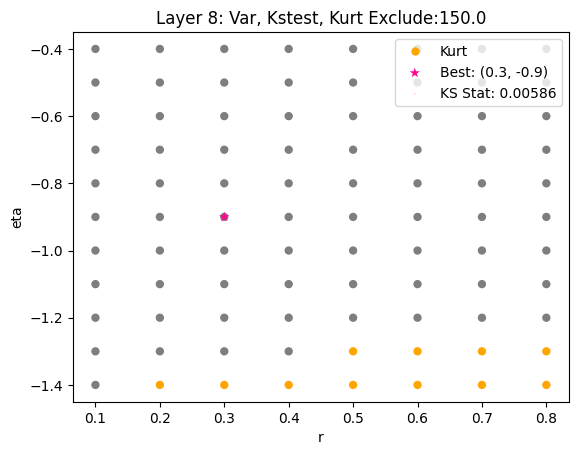

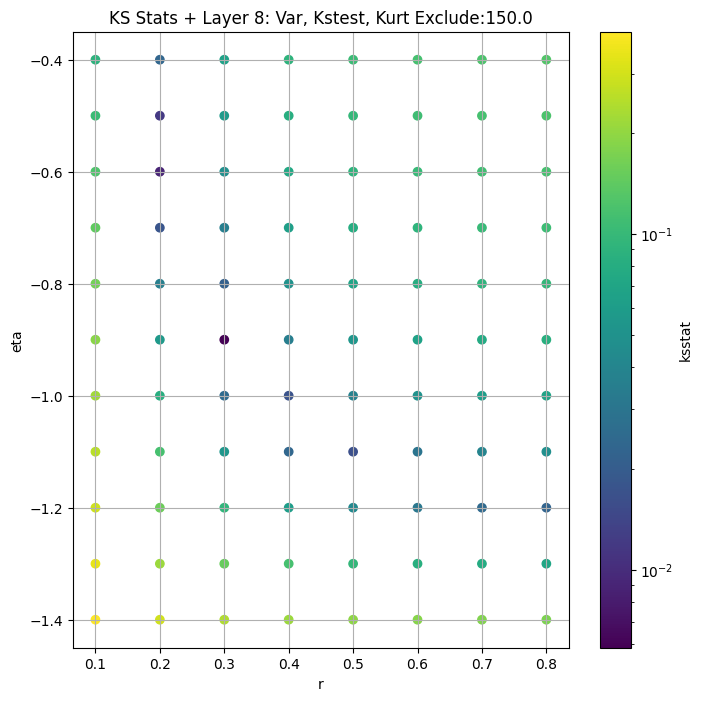

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.018852253030107402 0.06822876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.018830562847524934 0.062328327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.01745500559275981 0.059332654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.017847975362820123 0.056920975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.018994106902002095 0.054859504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.01922209899956645 0.0514139


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.019731066732632252 0.048569374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.021562851989043064 0.04613455


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.02035416992727912 0.04400727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.020389798675384097 0.04211617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.018525921979103965 0.037451897
Number of samples: 100000, Without approximation : 26279936


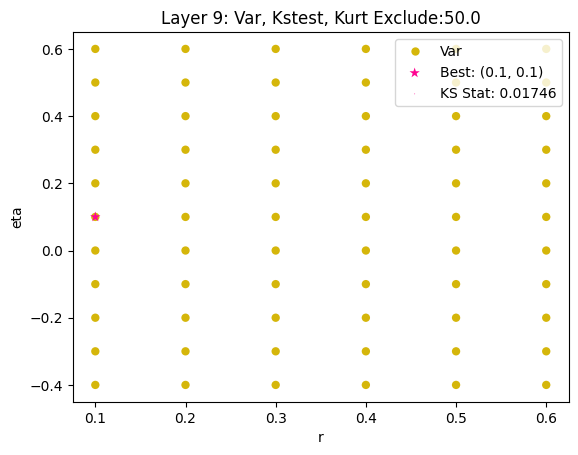

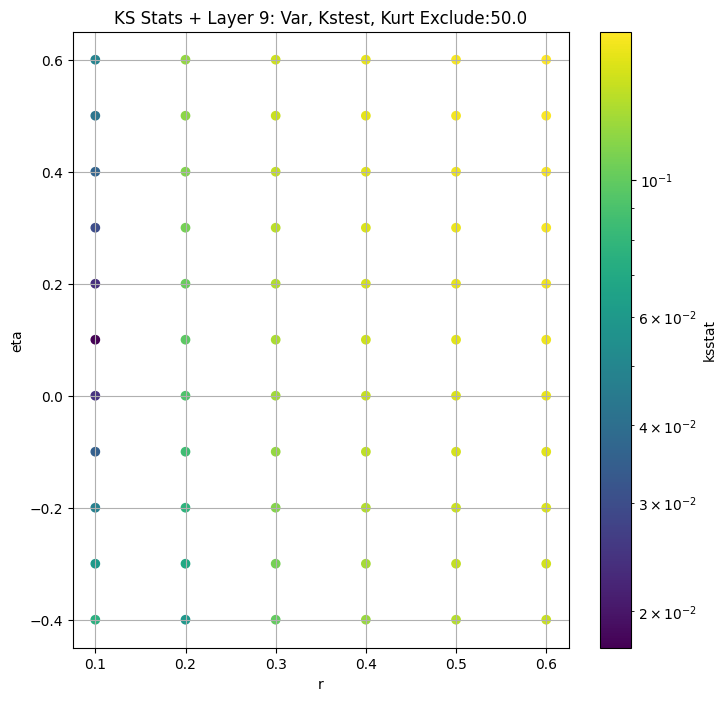

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      4899.646500  4445.868000  5360.411600   0.087138   -0.147728   
3      1238.654300  1163.662800  1315.236600   1.605114    1.235477   
4       263.909800   248.471220   279.795900   3.268377    2.747256   
5        51.531197    47.837180    55.759390   6.744933    4.699508   
6         9.183132     8.392665    10.085384  10.684343    7.591162   
7         1.610812     1.448076     1.795833  15.269720   10.921982   
8         0.307680     0.268638     0.360814  29.931046   15.846058   
9         0.068229     0.057962     0.083432  47.115646   21.587310   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.346288           1604             0.015611        8.7          0.3   
3        2.010365           6416             0.006765        1.9         -0.6   
4        3.893440          25664             0.002596        1.3         -0.9   
5       17.004566         102656             0.005407        0.7         -1.0   
6       24.656334         410624             0.008813        0.5         -1.0   
7       31.450808        1642496             0.013656        0.5         -1.1   
8      102.204470        6569984             0.005860        0.3         -0.9   
9      168.762150       26279936             0.017455        0.1          0.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       7.808866e+03                     0.0         4899.646500   
3       2.315959e+03                     0.0         1238.654300   
4       5.561209e+02                     0.0          263.909800   
5       6.150517e+01                     0.0           51.531197   
6       4.053411e+00                   150.0            8.106821   
7       1.015643e+00                    75.0            1.462525   
8       6.153407e-03                   150.0            0.246930   
9       5.002046e-15                    50.0            0.059333   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0759017508458717, var: 2675.201416015625


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.06378173457349379, var: 3033.75732421875


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.049593392560775496, var: 3486.5126953125


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.03362250838605757, var: 4067.4697265625


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.015611096961686, var: 4899.646484375
Number of samples: 1604, Without approximation : 1604


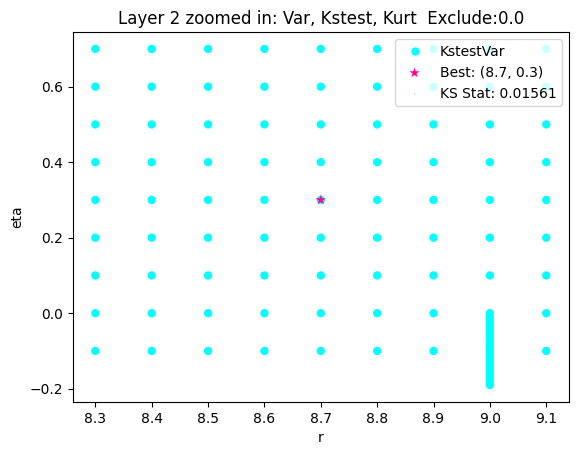

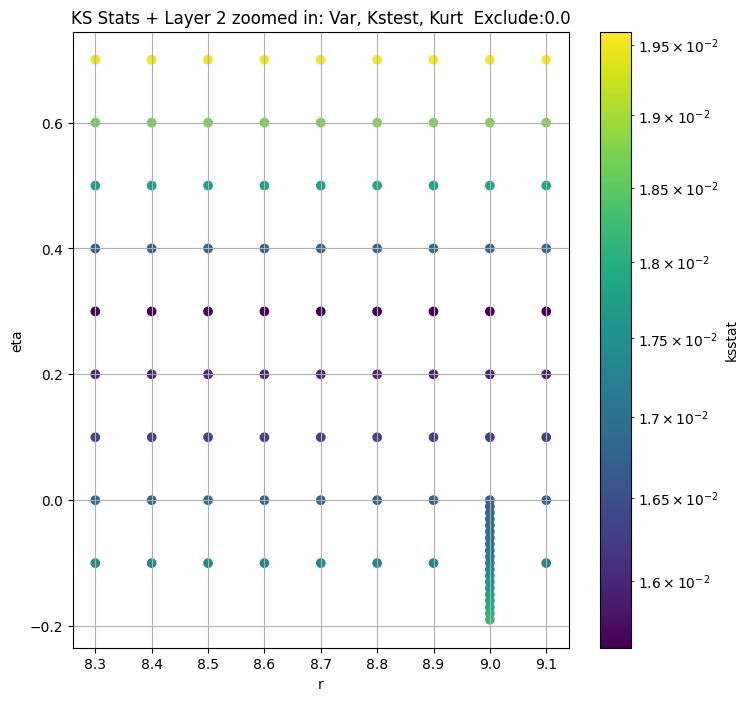

Layer 3


  0%|          | 0/1107 [00:00<?, ?it/s]

Finding Minimum after computing 1107 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.02661010256749062, var: 925.2639770507812


  0%|          | 0/1107 [00:00<?, ?it/s]

Finding Minimum after computing 1107 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.02203386958230405, var: 978.955078125


  0%|          | 0/1107 [00:00<?, ?it/s]

Finding Minimum after computing 1107 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.016927031982291896, var: 1040.6575927734375


  0%|          | 0/1107 [00:00<?, ?it/s]

Finding Minimum after computing 1107 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.012000922471786746, var: 1114.5064697265625


  0%|          | 0/1107 [00:00<?, ?it/s]

Finding Minimum after computing 1107 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.006439703634692262, var: 1238.654296875
Number of samples: 6416, Without approximation : 6416


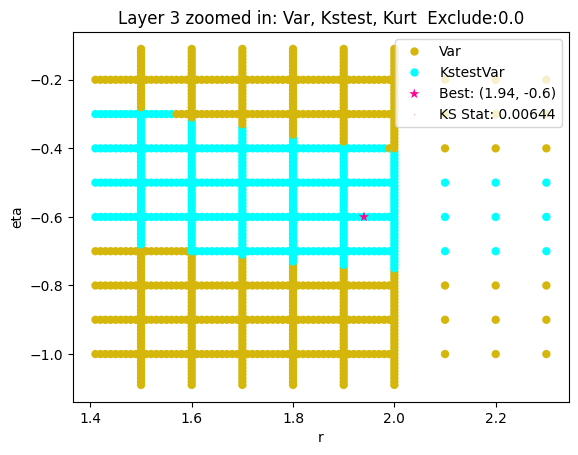

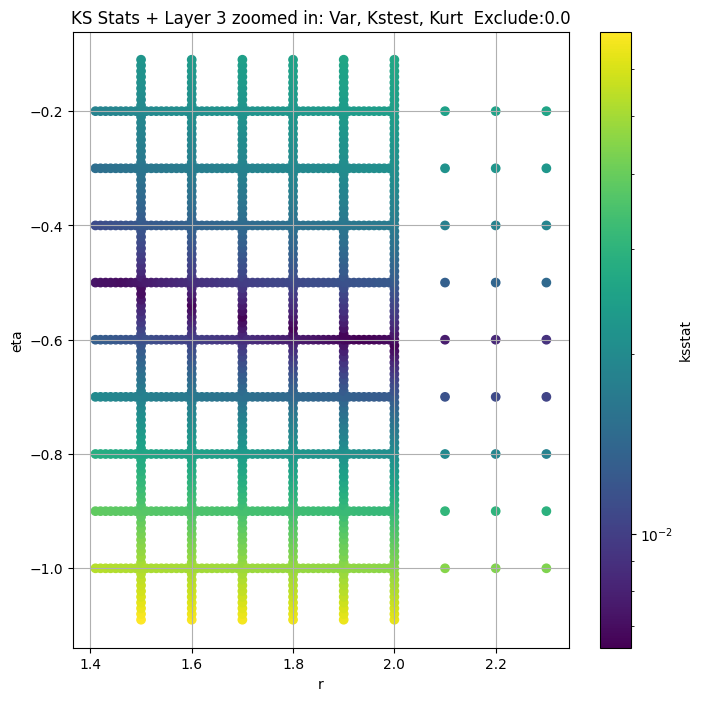

Layer 4


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.008159834686186362, var: 230.00247192382812


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.006676626499299232, var: 236.56097412109375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.005188497938000247, var: 243.82640075683594


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.0037807105913447714, var: 252.07940673828125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.002557894035448538, var: 263.9097900390625
Number of samples: 25664, Without approximation : 25664


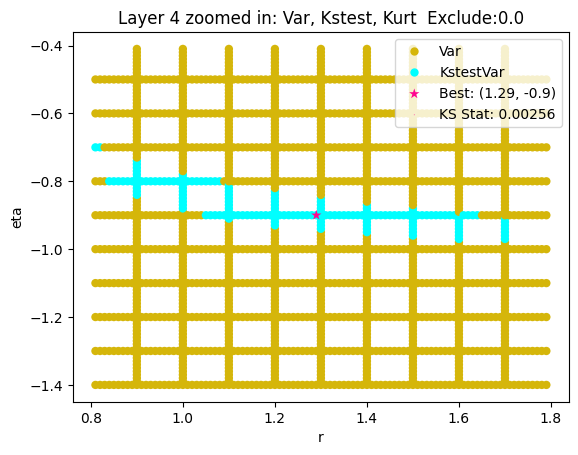

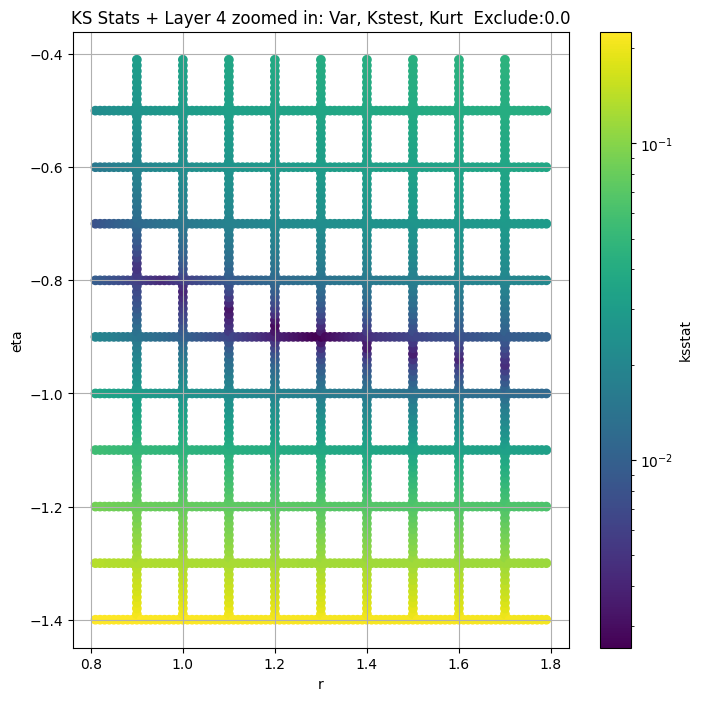

Layer 5


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.006147855960497717, var: 48.10011672973633


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.005663727577262634, var: 48.701786041259766


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.0055787176760148105, var: 49.379024505615234


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.005190258297674555, var: 50.17151641845703


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0050595963444118874, var: 51.53119659423828
Number of samples: 100000, Without approximation : 102656


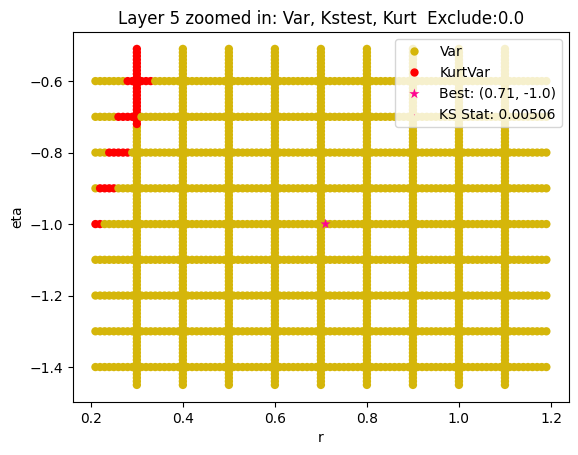

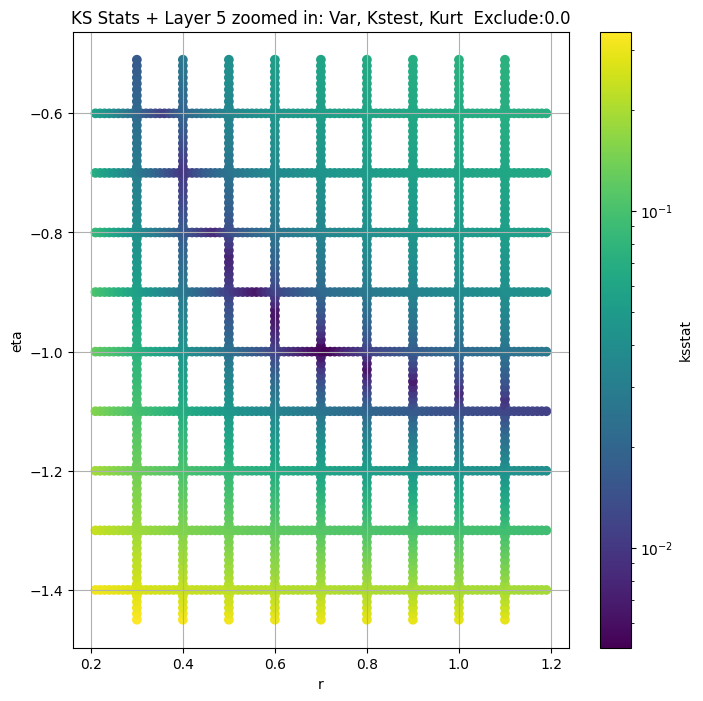

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 100 = 250, ksstat: 0.009233477461219108, var: 7.668834209442139


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 75 = 225, ksstat: 0.009025040283427432, var: 7.77029275894165


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 50 = 200, ksstat: 0.008845205206163609, var: 7.8765692710876465


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 25 = 175, ksstat: 0.00902340983209829, var: 7.988391876220703


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + 0 = 150, ksstat: 0.008812580410660471, var: 8.106821060180664


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + -25 = 125, ksstat: 0.008459462736424034, var: 8.232595443725586


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + -50 = 100, ksstat: 0.007737973068963788, var: 8.36745548248291


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + -75 = 75, ksstat: 0.0075935630580796845, var: 8.514945983886719


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 150.0 + -100 = 50, ksstat: 0.007648943687635246, var: 8.67951488494873
Number of samples: 100000, Without approximation : 410624


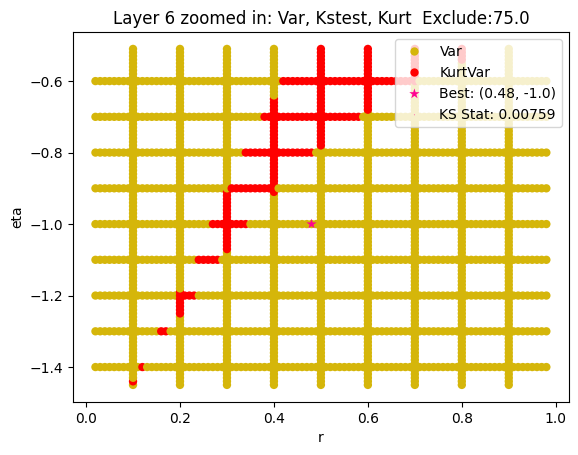

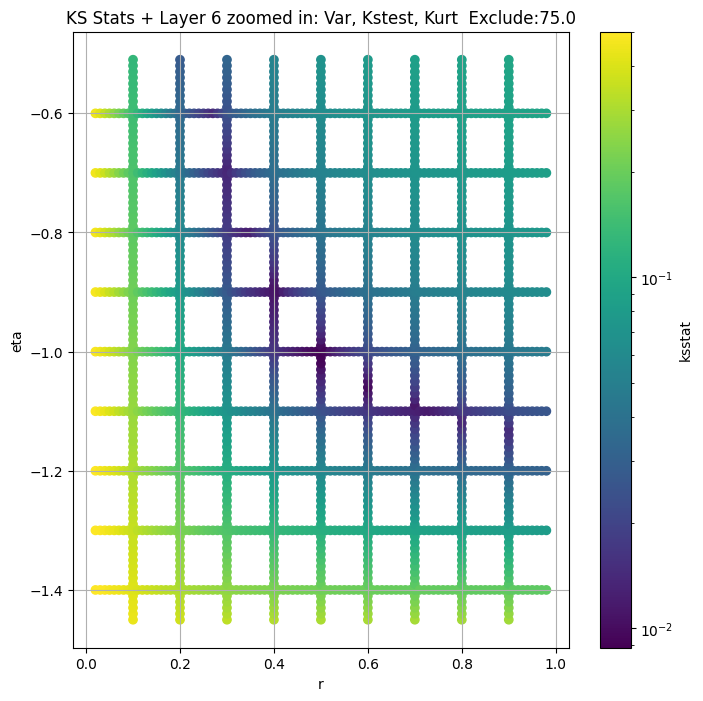

Layer 7


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 75.0 + 100 = 175, ksstat: 0.013411805625450468, var: 1.3483887910842896


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 75.0 + 75 = 150, ksstat: 0.013607567080123117, var: 1.3738187551498413


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 75.0 + 50 = 125, ksstat: 0.013175449080647827, var: 1.4009655714035034


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 75.0 + 25 = 100, ksstat: 0.013646232114722878, var: 1.4302647113800049


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 75.0 + 0 = 75, ksstat: 0.013655652946161334, var: 1.462525486946106


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 75.0 + -25 = 50, ksstat: 0.013690594653308186, var: 1.4988715648651123


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 75.0 + -50 = 25, ksstat: 0.013504675809140665, var: 1.54152250289917


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 75.0 + -75 = 0, ksstat: 0.01312101835366497, var: 1.6108125448226929
Number of samples: 100000, Without approximation : 1642496


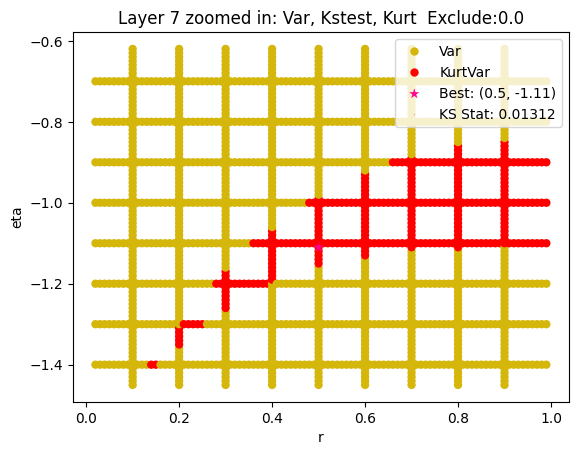

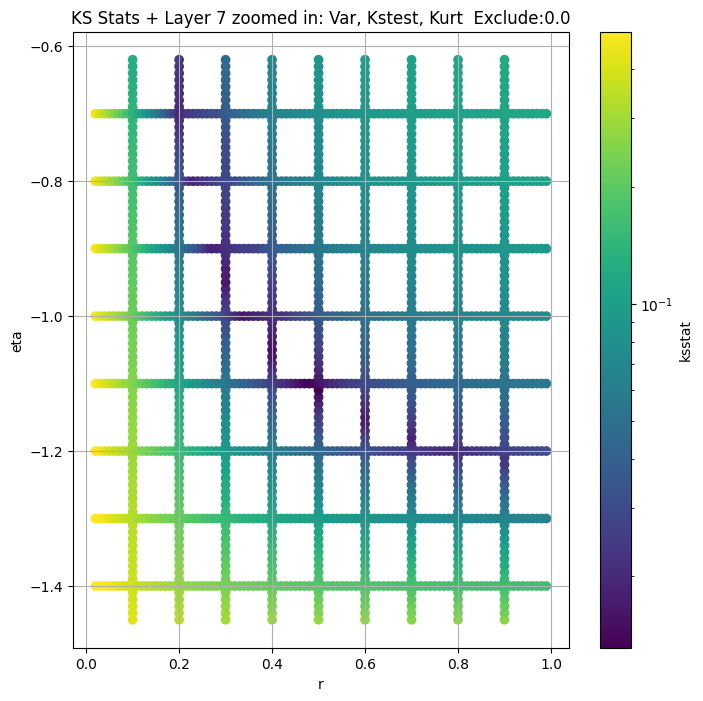

Layer 8


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.0067942833088169285, var: 0.22578008472919464


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.0071293267962959095, var: 0.23056861758232117


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.006612591432745202, var: 0.23565682768821716


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.006322998780102597, var: 0.24108953773975372


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.005860252586747078, var: 0.2469298094511032


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.005367798668640157, var: 0.25326138734817505


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.005178735968584092, var: 0.2602129280567169


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.005075364429237398, var: 0.2679513394832611


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.005383357678470091, var: 0.27680864930152893
Number of samples: 100000, Without approximation : 6569984


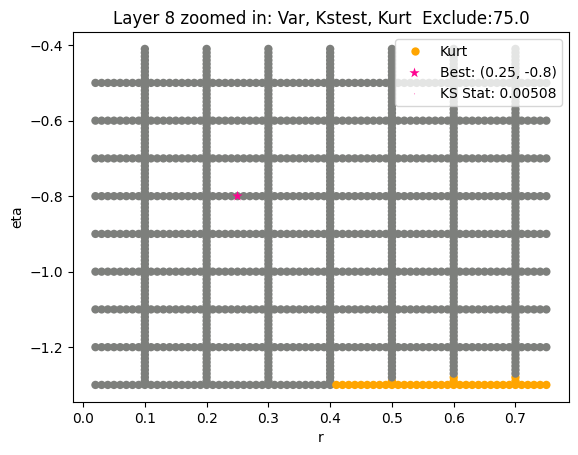

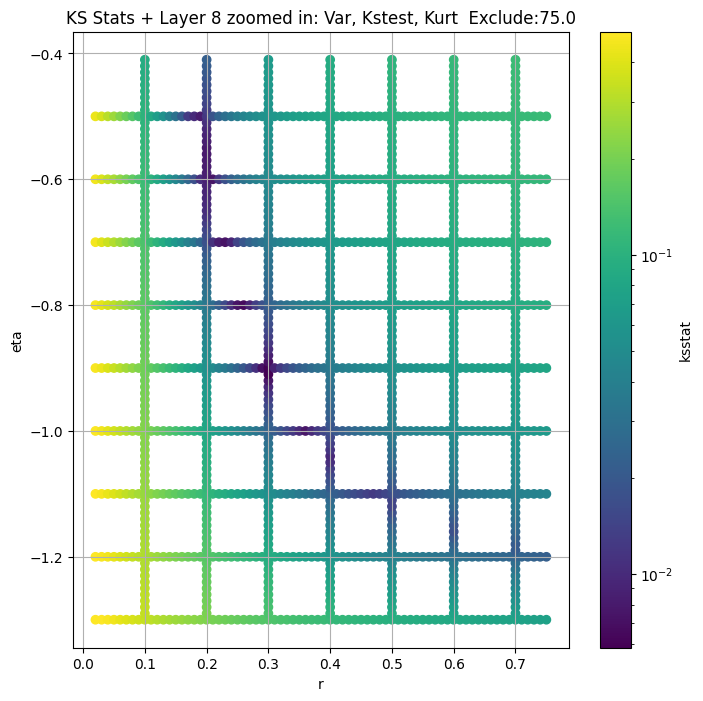

Layer 9


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 9, 50.0 + 100 = 150, ksstat: 0.01762011791794138, var: 0.05141390115022659


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 9, 50.0 + 75 = 125, ksstat: 0.01764441714740861, var: 0.05304303765296936


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 9, 50.0 + 50 = 100, ksstat: 0.018644488729650355, var: 0.054859504103660583


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 9, 50.0 + 25 = 75, ksstat: 0.017464295512380712, var: 0.05692097544670105


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 9, 50.0 + 0 = 50, ksstat: 0.01745500559275981, var: 0.059332653880119324


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 9, 50.0 + -25 = 25, ksstat: 0.017576110874932382, var: 0.06232832744717598


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 9, 50.0 + -50 = 0, ksstat: 0.01794541079143319, var: 0.06822875887155533
Number of samples: 100000, Without approximation : 26279936


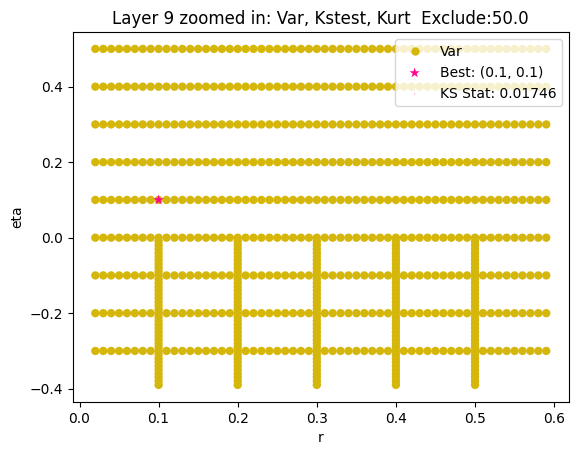

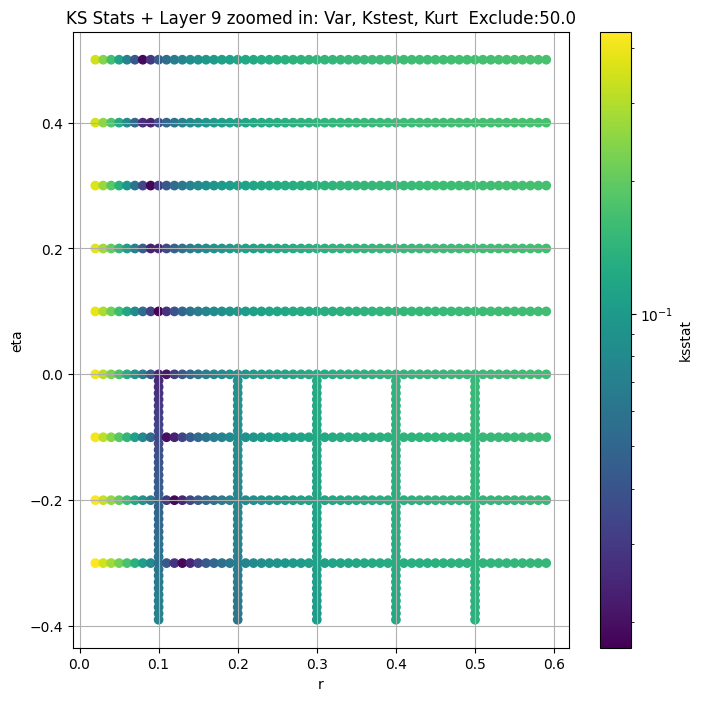

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      4899.646500  4445.868000  5360.411600   0.087138   -0.147728   
3      1238.654300  1163.662800  1315.236600   1.605114    1.235477   
4       263.909800   248.471220   279.795900   3.268377    2.747256   
5        51.531197    47.837180    55.759390   6.744933    4.699508   
6         9.183132     8.392665    10.085384  10.684343    7.591162   
7         1.610812     1.448076     1.795833  15.269720   10.921982   
8         0.307680     0.268638     0.360814  29.931046   15.846058   
9         0.068229     0.057962     0.083432  47.115646   21.587310   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.346288           1604             0.015611        8.7          0.3   
3        2.010365           6416             0.006765        1.9         -0.6   
4        3.893440          25664             0.002596        1.3         -0.9   
5       17.004566         102656             0.005407        0.7         -1.0   
6       24.656334         410624             0.008813        0.5         -1.0   
7       31.450808        1642496             0.013656        0.5         -1.1   
8      102.204470        6569984             0.005860        0.3         -0.9   
9      168.762150       26279936             0.017455        0.1          0.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       7.808866e+03                     0.0         4899.646500   
3       2.315959e+03                     0.0         1238.654297   
4       5.561209e+02                     0.0          263.909790   
5       6.150517e+01                     0.0           51.531197   
6       4.053411e+00                   150.0            8.514946   
7       1.015643e+00                    75.0            1.610813   
8       6.153407e-03                   150.0            0.267951   
9       5.002046e-15                    50.0            0.059333   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.015611    8.70      0.30   
3                     0.016929          0.006440    1.94     -0.60   
4                     0.008471          0.002558    1.29     -0.90   
5                     0.004237          0.005060    0.71     -1.00   
6                     0.002119          0.007594    0.48     -1.00   
7                     0.001060          0.013121    0.50     -1.11   
8                     0.000530          0.005075    0.25     -0.80   
9                     0.000265          0.017455    0.10      0.10   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      7.808866e+03                  0.0         7704  
3      2.335756e+03                  0.0        46245  
4      5.531373e+02                  0.0       292329  
5      6.319886e+01                  0.0        73081  
6      3.697439e+00                 75.0        32481  
7      1.160193e+00                  0.0        10827  
8      9.045760e-04                 75.0        73081  
9      5.002046e-15                 50.0         6088

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

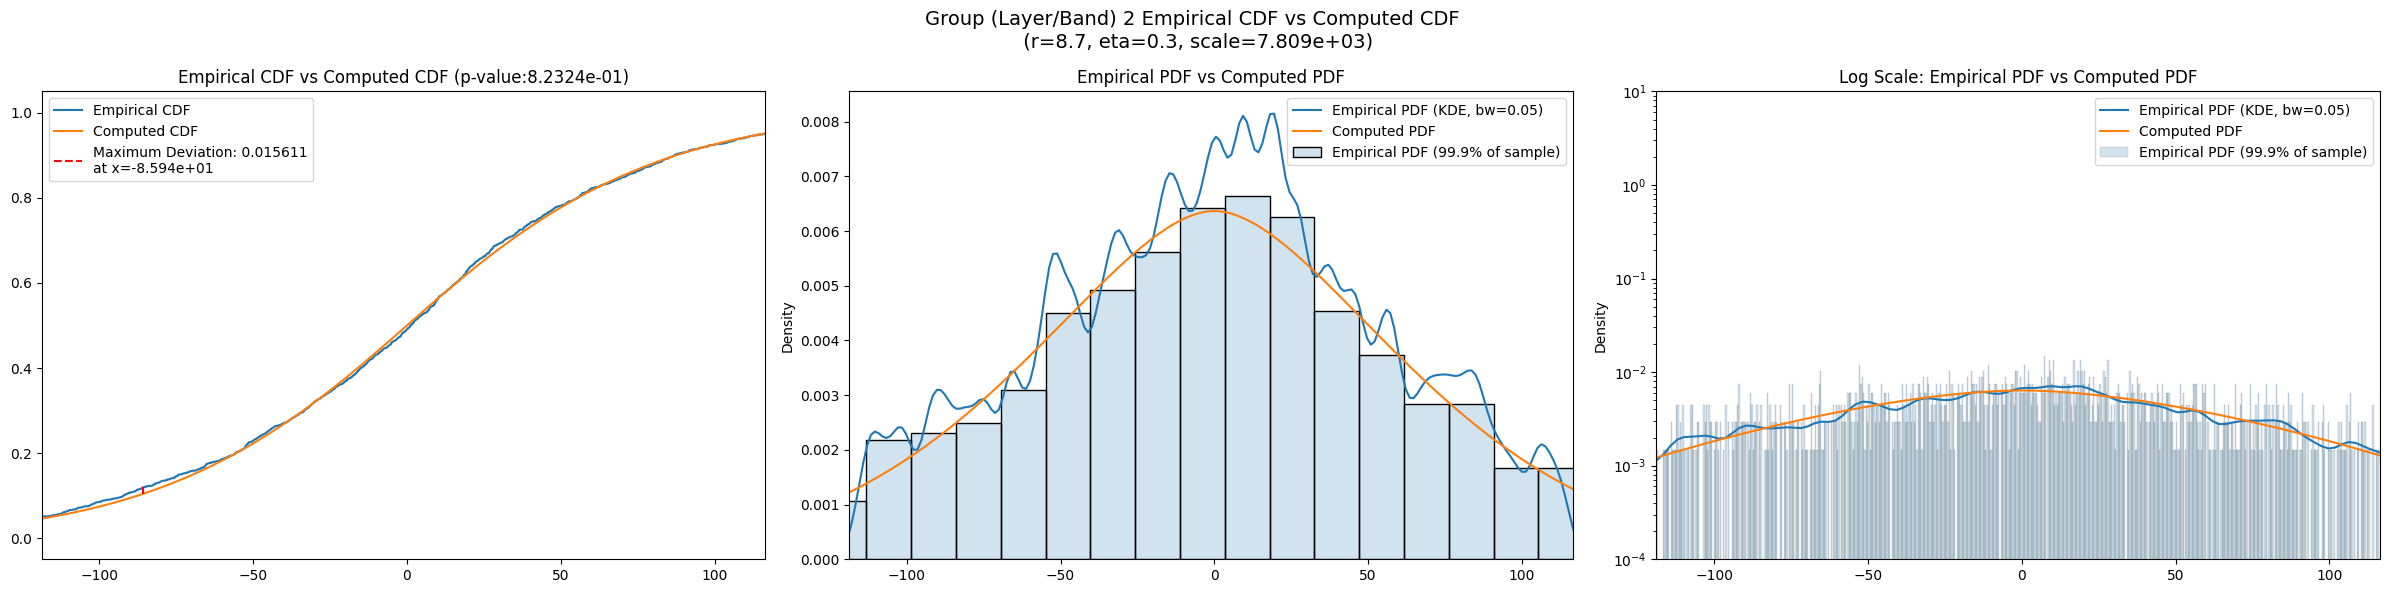

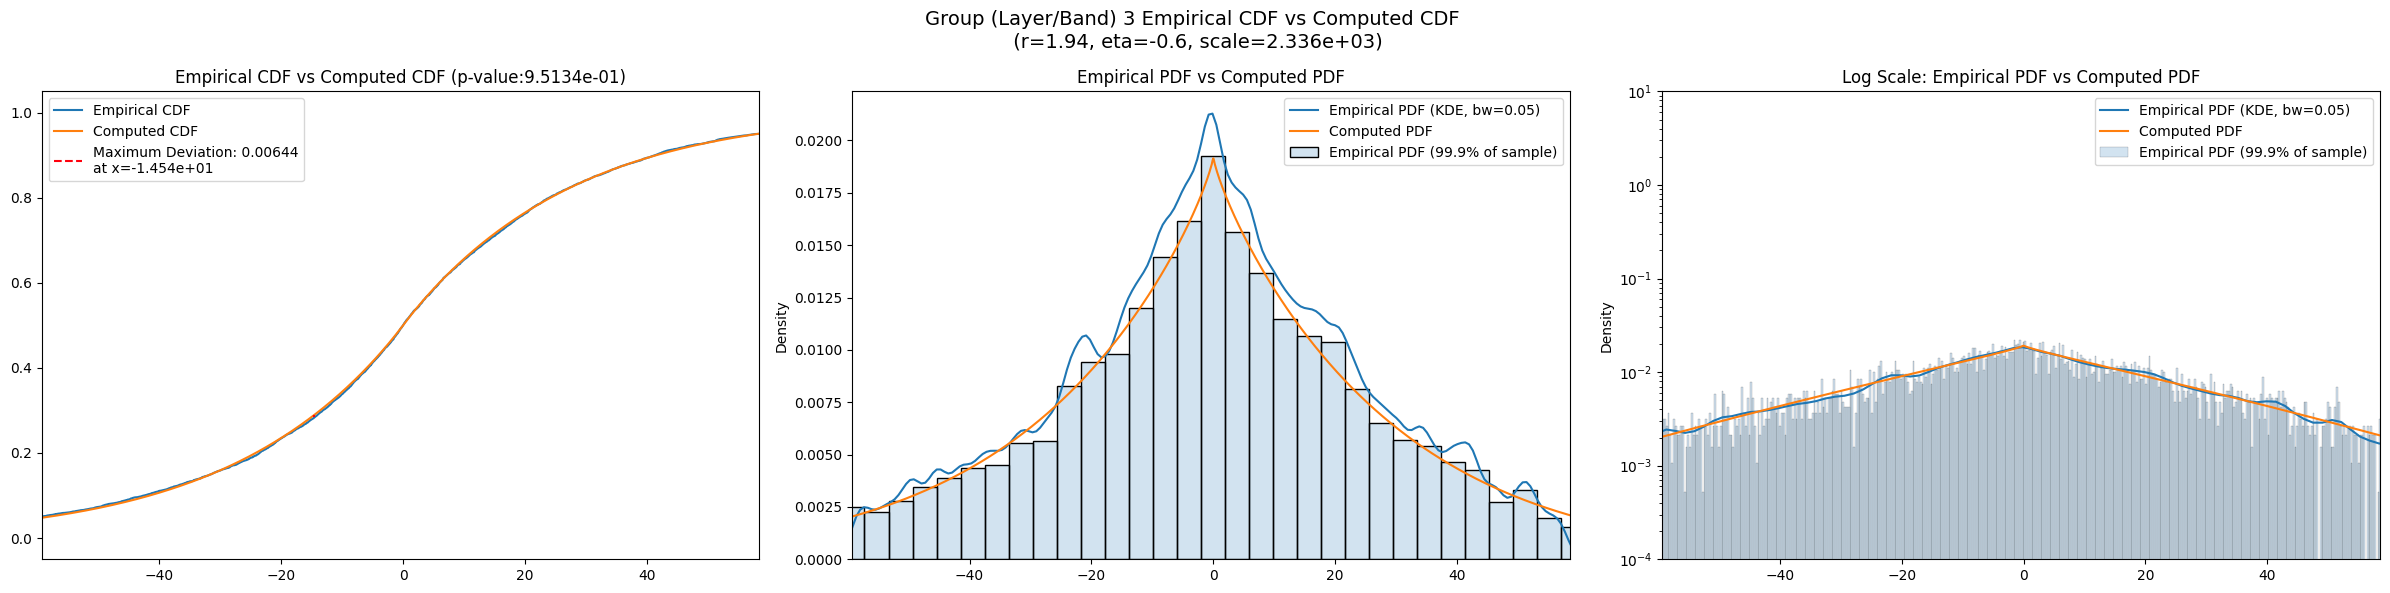

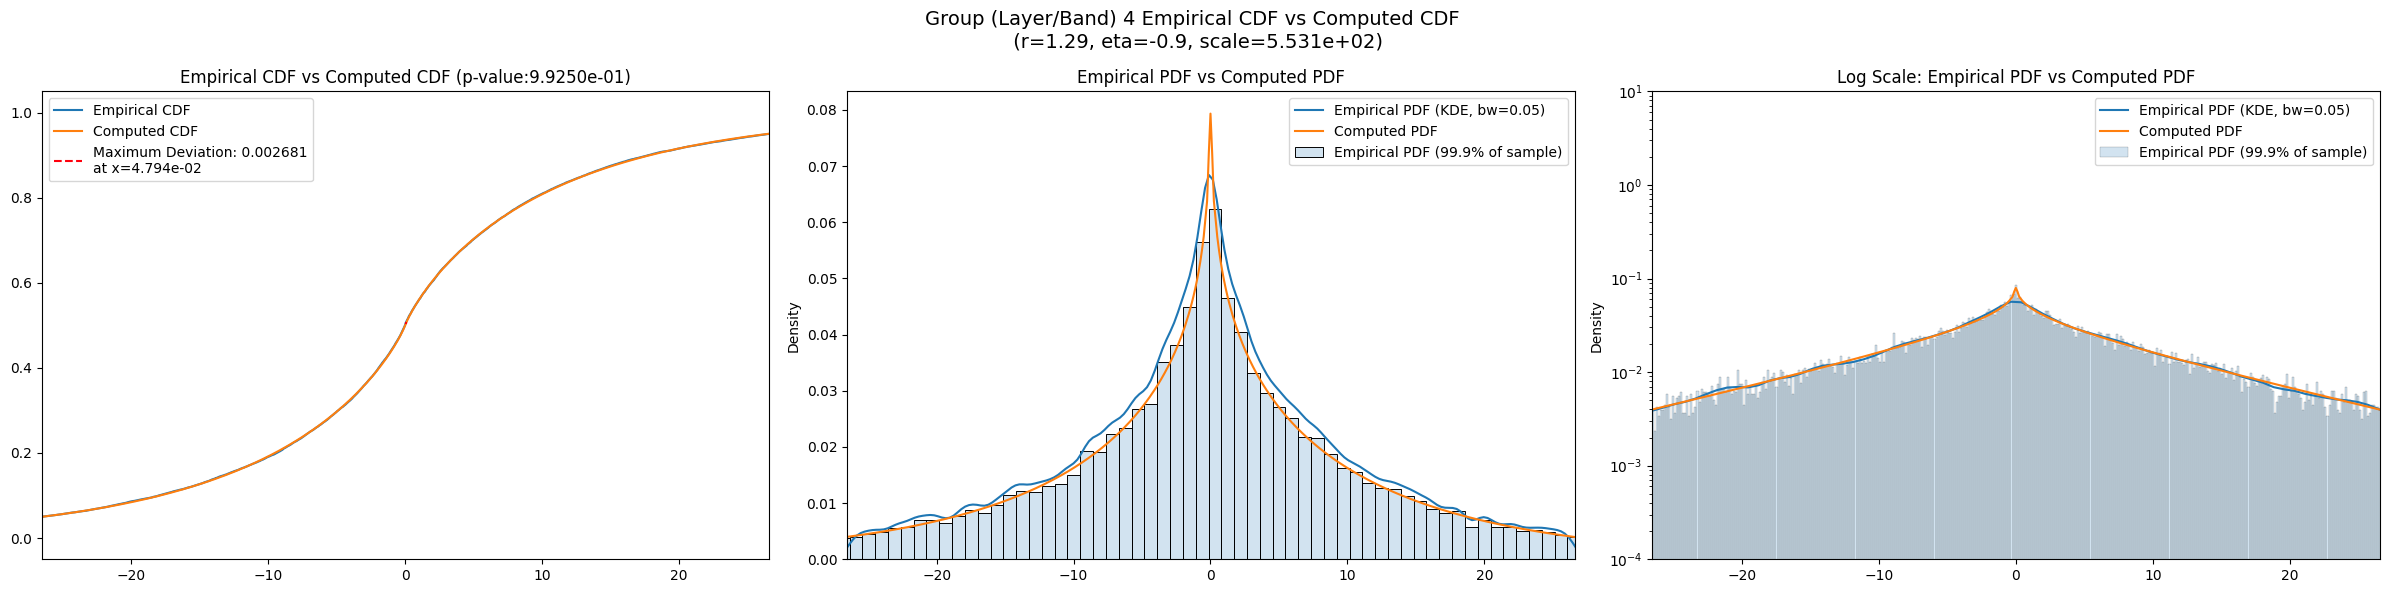

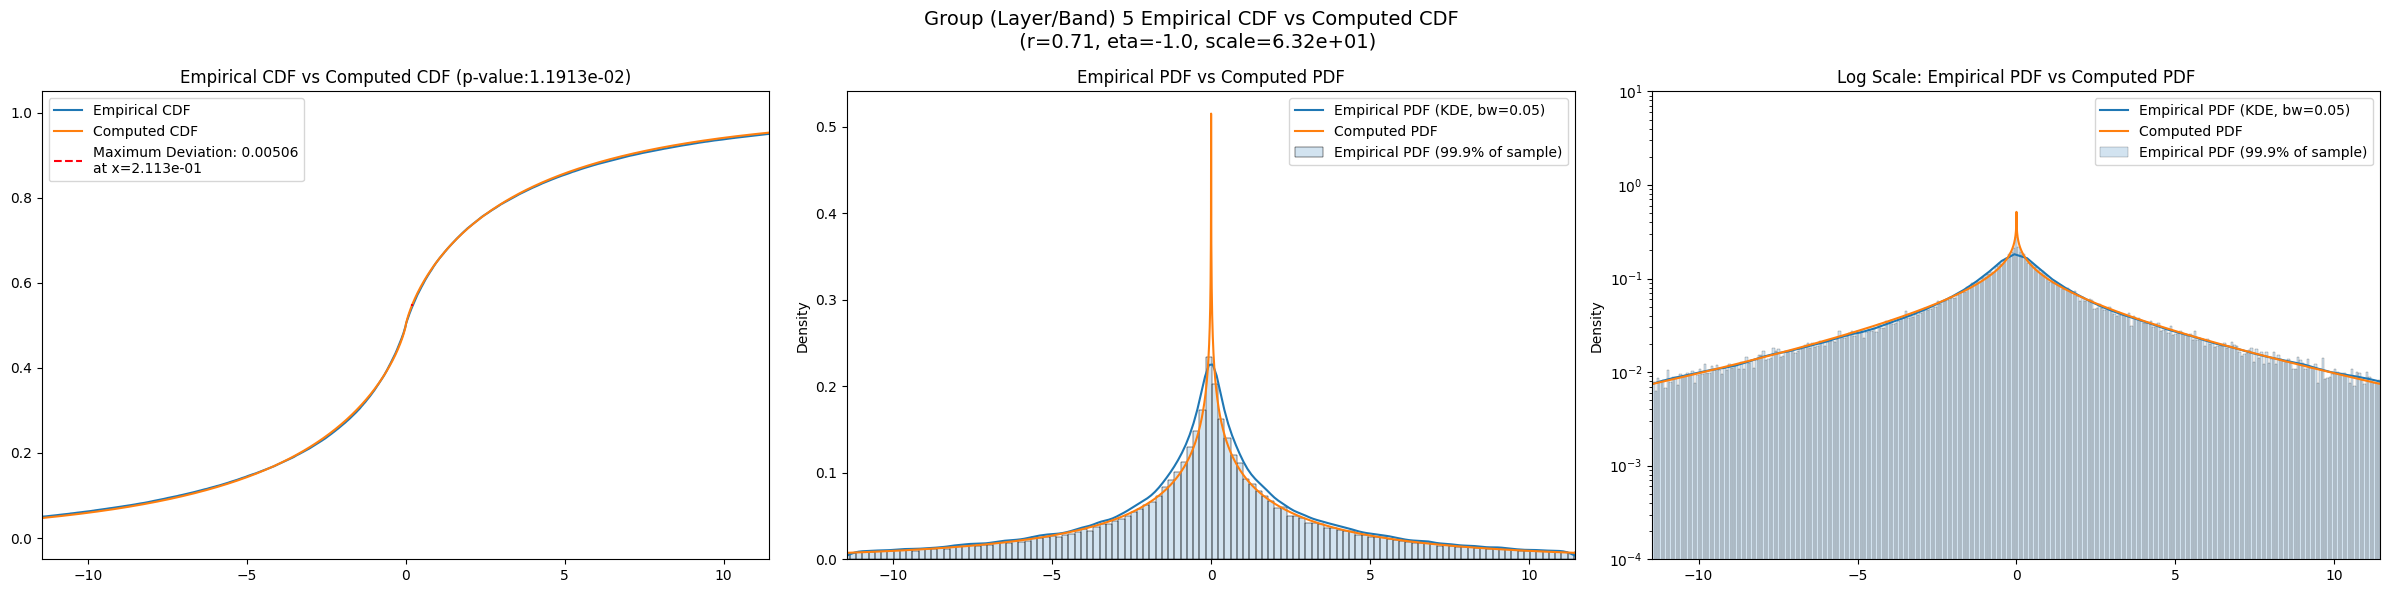

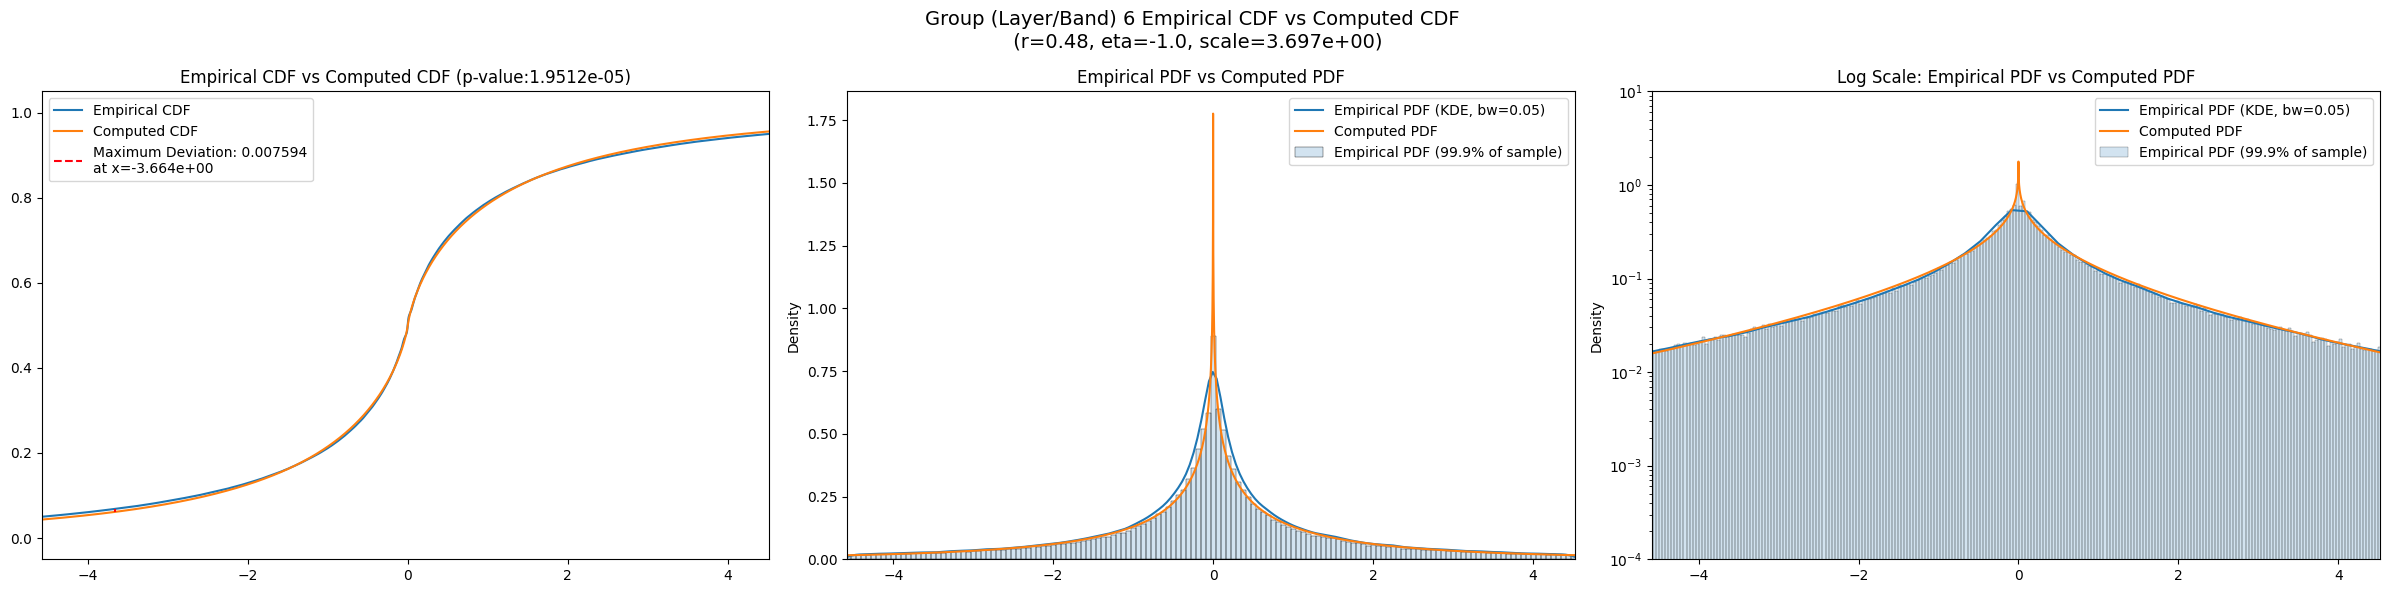

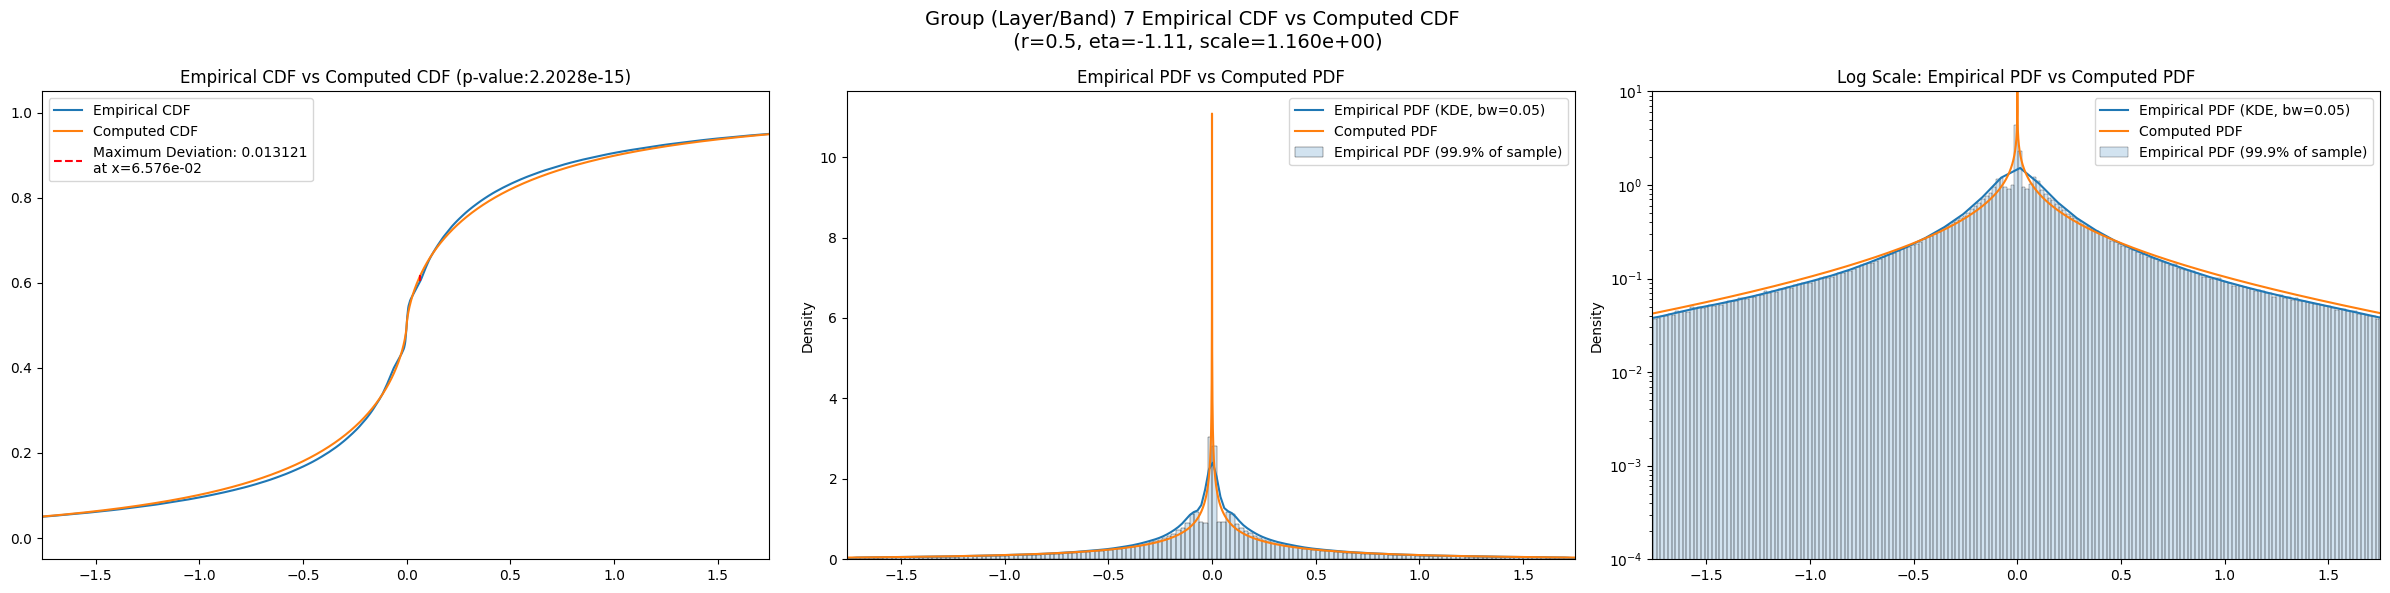

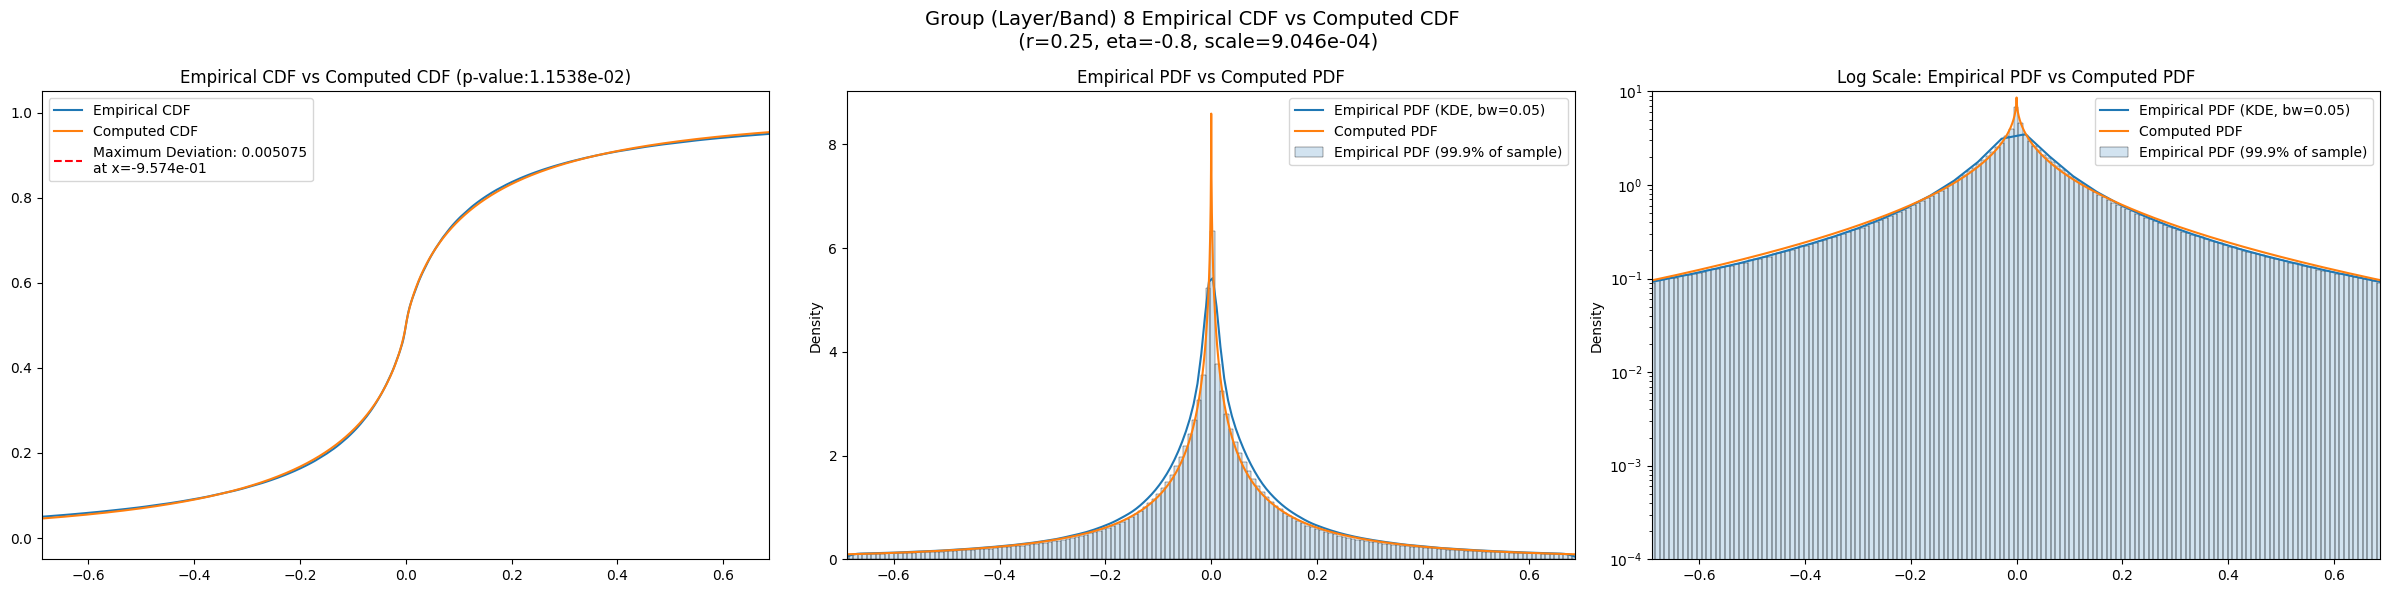

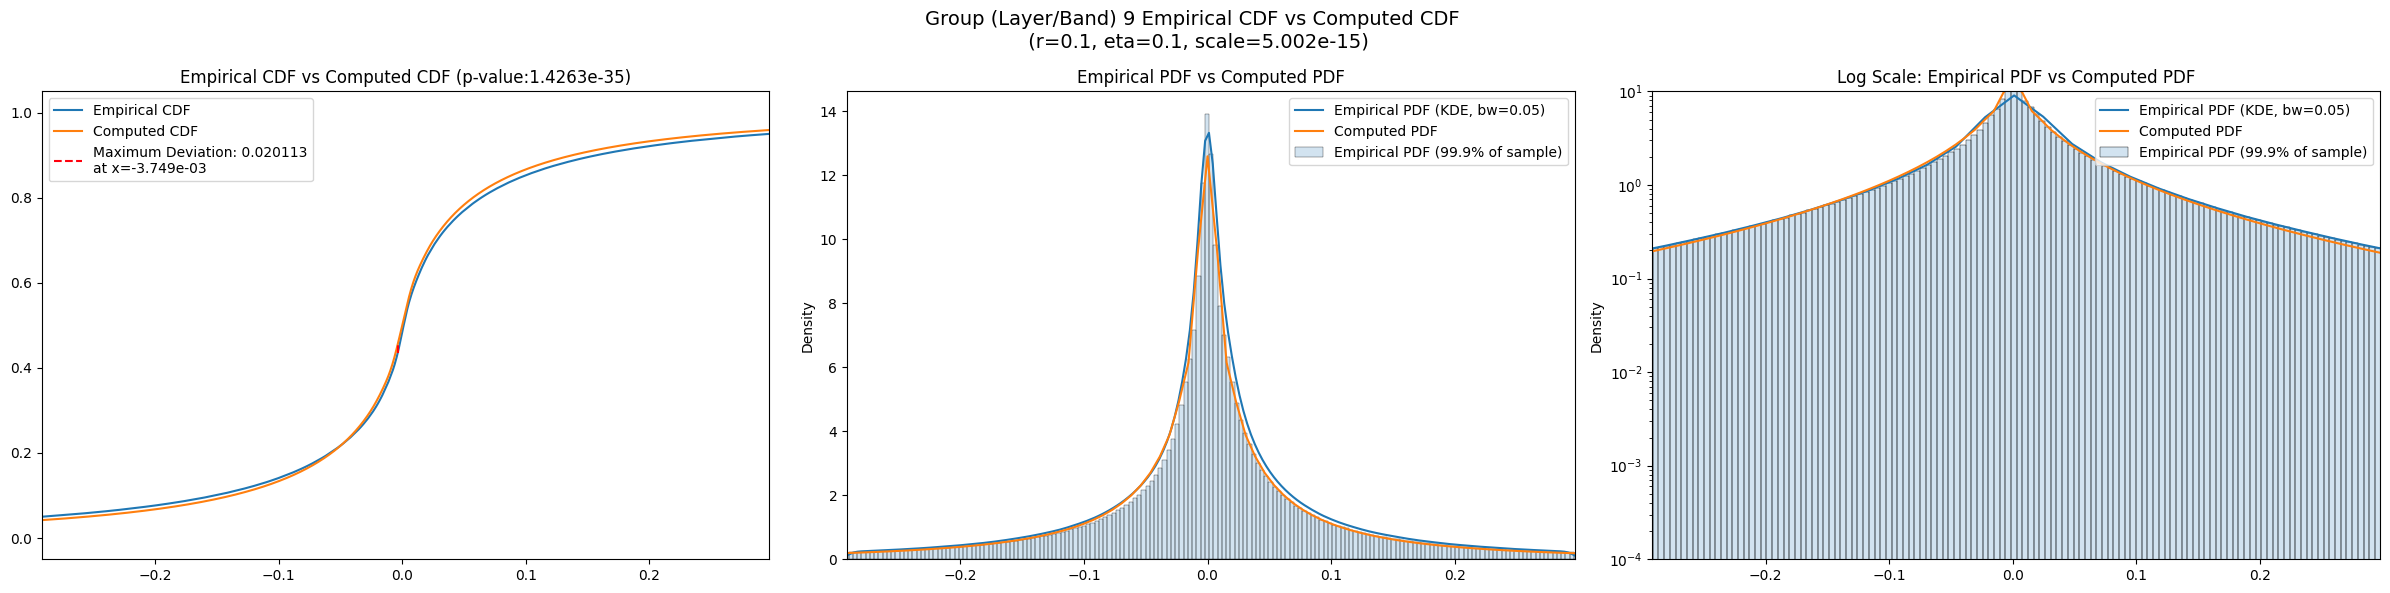

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      4899.646500  4445.868000  5360.411600   0.087138   -0.147728   
3      1238.654300  1163.662800  1315.236600   1.605114    1.235477   
4       263.909800   248.471220   279.795900   3.268377    2.747256   
5        51.531197    47.837180    55.759390   6.744933    4.699508   
6         9.183132     8.392665    10.085384  10.684343    7.591162   
7         1.610812     1.448076     1.795833  15.269720   10.921982   
8         0.307680     0.268638     0.360814  29.931046   15.846058   
9         0.068229     0.057962     0.083432  47.115646   21.587310   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.346288           1604             0.015611        8.7          0.3   
3        2.010365           6416             0.006765        1.9         -0.6   
4        3.893440          25664             0.002596        1.3         -0.9   
5       17.004566         102656             0.005407        0.7         -1.0   
6       24.656334         410624             0.008813        0.5         -1.0   
7       31.450808        1642496             0.013656        0.5         -1.1   
8      102.204470        6569984             0.005860        0.3         -0.9   
9      168.762150       26279936             0.017455        0.1          0.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       66.477400              0.021666          4.327580e-01   
3      ...       29.554500              0.030168          1.657920e-05   
4      ...       11.743000              0.042868          2.032180e-41   
5      ...        4.161880              0.060094          0.000000e+00   
6      ...        1.406250              0.071052          0.000000e+00   
7      ...        0.507399              0.072151          0.000000e+00   
8      ...        0.198526              0.070284          0.000000e+00   
9      ...        0.075824              0.081503          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          58.348200             0.023998         3.090940e-01  47.926600   
3          26.458100             0.007447         8.662020e-01  21.293300   
4          10.212200             0.016146         3.054750e-06   8.375010   
5           3.611190             0.033040         8.551700e-98   2.890370   
6           1.220040             0.044844         0.000000e+00   0.952952   
7           0.444768             0.046162         0.000000e+00   0.345418   
8           0.174802             0.044508         0.000000e+00   0.134644   
9           0.065755             0.055822         0.000000e+00   0.051013   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.031152   8.705960e-02          8.232421e-01  
3           0.015595   8.732940e-02          9.513435e-01  
4           0.021327   1.428390e-10          9.959200e-01  
5           0.035661  7.324110e-114          1.039810e-02  
6           0.045864   0.000000e+00          5.402296e-21  
7           0.045283   0.000000e+00         4.818304e-246  
8           0.043471   0.000000e+00         1.999862e-147  
9           0.056579   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.015611                 0.033804          0.015611   
3                 0.006765                 0.016929          0.006440   
4                 0.002596                 0.008471          0.002558   
5                 0.005407                 0.004237          0.005060   
6                 0.008813                 0.002119          0.007594   
7                 0.013656                 0.001060          0.013121   
8                 0.005860                 0.000530          0.005075   
9                 0.017455                 0.000265          0.017455   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.021666             0.023998       0.031152  
3                  0.030168             0.007447       0.015595  
4                  0.042868             0.016146       0.021327  
5                  0.060094             0.033040       0.035661  
6                  0.071052             0.044844       0.045864  
7                  0.072151             0.046162       0.045283  
8                  0.070284             0.044508       0.043471  
9                  0.081503             0.055822       0.056579

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             4899.646500          0.015611    8.70      0.30  7.808866e+03   
3             1238.654297          0.006440    1.94     -0.60  2.335756e+03   
4              263.909790          0.002558    1.29     -0.90  5.531373e+02   
5               51.531197          0.005060    0.71     -1.00  6.319886e+01   
6                8.514946          0.007594    0.48     -1.00  3.697439e+00   
7                1.610813          0.013121    0.50     -1.11  1.160193e+00   
8                0.267951          0.005075    0.25     -0.80  9.045760e-04   
9                0.059333          0.017455    0.10      0.10  5.002046e-15   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                     75.0  
7                      0.0  
8                     75.0  
9                     50.0

In [21]:
eng.quit()